In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# DATASET BITCOIN


In [85]:
# Load CSV File
df = pd.read_csv('Bitcoin Historical Data.csv')
print(df)

           Date      Price       Open       High        Low    Vol. Change %
0      6/1/2024  67,760.80  67,533.90  67,861.00  67,449.60  19.01K    0.34%
1     5/31/2024  67,530.10  68,352.30  69,018.20  66,676.80  61.51K   -1.21%
2     5/30/2024  68,354.70  67,631.30  69,504.70  67,138.40  66.84K    1.06%
3     5/29/2024  67,635.80  68,366.20  68,897.60  67,143.20  52.13K   -1.07%
4     5/28/2024  68,366.00  69,428.30  69,560.70  67,299.90  71.39K   -1.53%
...         ...        ...        ...        ...        ...     ...      ...
4106   3/5/2013       40.3       36.2       40.7       36.2  85.43K   11.56%
4107   3/4/2013       36.2       34.5       36.7       34.2  46.77K    4.78%
4108   3/3/2013       34.5       34.3       34.5       33.8  12.53K    0.73%
4109   3/2/2013       34.3       34.5       34.8       33.2  36.66K   -0.72%
4110   3/1/2013       34.5       33.4       34.9       32.9  39.79K    3.36%

[4111 rows x 7 columns]


In [86]:
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
data = df
df1 = df_reversed['Price']
df1 = df1.str.replace(',', '').astype(float)

In [87]:
# Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

### RETIO 6:4

In [88]:
# Split Train and Test Data
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [89]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [90]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [91]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [92]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [93]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.5236e-04
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.0254e-05
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.2179e-05
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.4301e-05
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.4370e-05
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.5677e-05
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.5668e-05
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.1664e-05
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.9296e-05
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.7117e-05
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.2889e-05
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.8880e-05
Epoch 13/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.9477e-05
Epoch 14/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.8709e-05
E

In [94]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [95]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [96]:
last_input = test_data[-time_step:].reshape(1, -1)

In [97]:
# Forecast Next 30 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output30 = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output30.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output30.extend(yhat.tolist())
        i += 1
forecast_30_days = 30
forecast_30_output = scaler.inverse_transform(lst_output30)

In [98]:
# Forecast Next 60 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output60 = []
i = 0
while i < 60:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output60.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output60.extend(yhat.tolist())
        i += 1
forecast_60_days = 60
forecast_60_output = scaler.inverse_transform(lst_output60)

In [99]:
# Forecast Next 90 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output90.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output90.extend(yhat.tolist())
        i += 1
forecast_90_days = 90
forecast_90_output = scaler.inverse_transform(lst_output90)

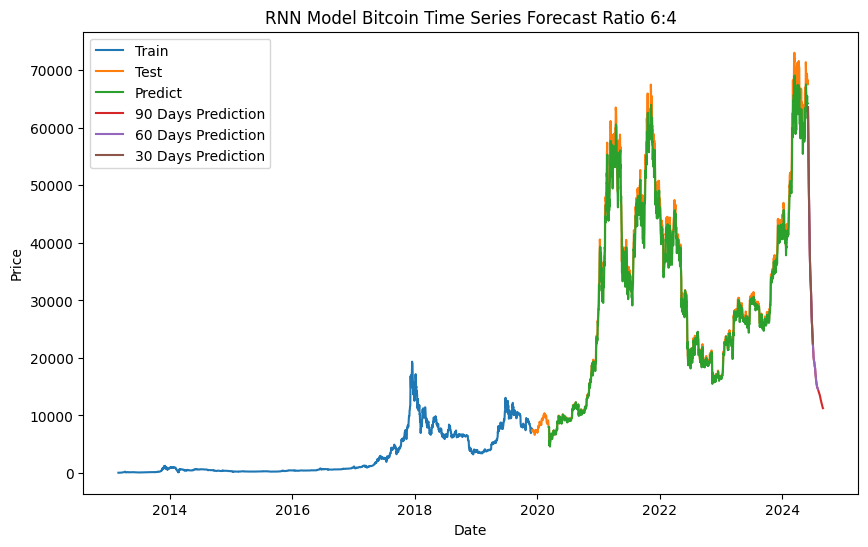

In [100]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))
dates = pd.to_datetime(data['Date'])

train_data_index = dates[:train_size]
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = dates[train_size:]
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(dates, test_predict_plot, label='Predict')

last_date = dates.iloc[-1]

# Plot next 90-days future
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
plt.plot(future_dates_90, forecast_90_output, label='90 Days Prediction')

# Plot next 60-days future
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
plt.plot(future_dates_60, forecast_60_output, label='60 Days Prediction')

# Plot next 30-days future
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates_30, forecast_30_output, label='30 Days Prediction')

# Adding legends and labels
plt.title('RNN Model Bitcoin Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

Testing RMSE: 1876.8718142573184
Testing MAE: 1253.2235544471544
Testing MAPE: 3.4037383851070855


### RETIO 7:3

In [102]:
# Split Train and Test Data
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [103]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [104]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [105]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [106]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [107]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.7743e-04
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.6748e-05
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.8752e-05
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.8669e-05
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.8099e-05
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.9883e-05
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.8946e-05
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.6806e-05
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.6940e-05
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.8320e-05
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.0168e-05
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.4322e-05
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.2500e-05
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.2562e-05
E

In [108]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [109]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [110]:
last_input = test_data[-time_step:].reshape(1, -1)

In [111]:
# Forecast Next 30 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output30 = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output30.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output30.extend(yhat.tolist())
        i += 1
forecast_30_days = 30
forecast_30_output = scaler.inverse_transform(lst_output30)

In [112]:
# Forecast Next 60 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output60 = []
i = 0
while i < 60:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output60.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output60.extend(yhat.tolist())
        i += 1
forecast_60_days = 60
forecast_60_output = scaler.inverse_transform(lst_output60)

In [113]:
# Forecast Next 90 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output90.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output90.extend(yhat.tolist())
        i += 1
forecast_90_days = 90
forecast_90_output = scaler.inverse_transform(lst_output90)

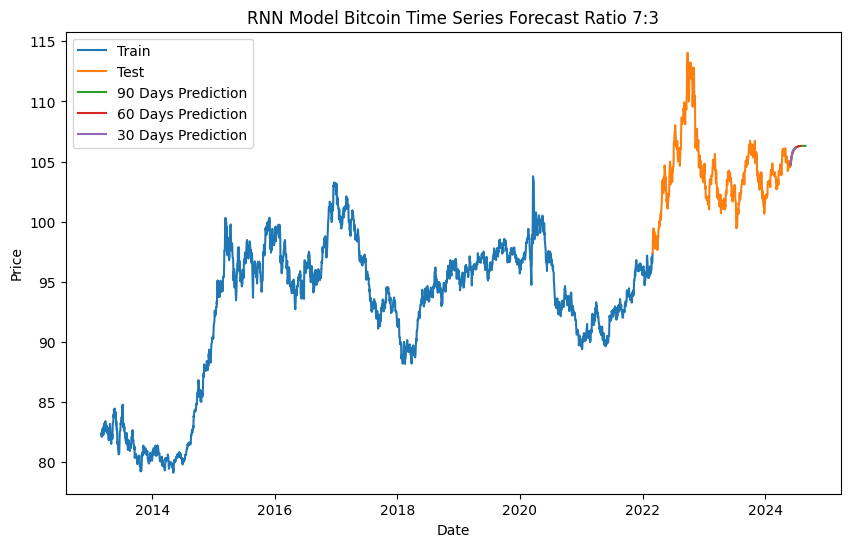

In [220]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))
dates = pd.to_datetime(data['Date'])

train_data_index = dates[:train_size]
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = dates[train_size:]
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
#plt.plot(dates, test_predict_plot, label='Predict')

last_date = dates.iloc[-1]

# Plot next 90-days future
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
plt.plot(future_dates_90, forecast_90_output, label='90 Days Prediction')

# Plot next 60-days future
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
plt.plot(future_dates_60, forecast_60_output, label='60 Days Prediction')

# Plot next 30-days future
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates_30, forecast_30_output, label='30 Days Prediction')

# Adding legends and labels
plt.title('RNN Model Bitcoin Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

Testing RMSE: 1422.9182348037123
Testing MAE: 995.0912476555607
Testing MAPE: 2.722267168777402


### RETIO 8:2

In [116]:
# Split Train and Test Data
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [117]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [118]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [119]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [120]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [121]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0182
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.2572e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.0371e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.4654e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.5356e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.0514e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.0615e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.8853e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.6202e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7649e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.2404e-04
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.3955e-04
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4895e-04
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.2705e-04
Epoch

In [122]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [123]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [124]:
last_input = test_data[-time_step:].reshape(1, -1)

In [125]:
# Forecast Next 30 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output30 = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output30.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output30.extend(yhat.tolist())
        i += 1
forecast_30_days = 30
forecast_30_output = scaler.inverse_transform(lst_output30)

In [126]:
# Forecast Next 60 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output60 = []
i = 0
while i < 60:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output60.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output60.extend(yhat.tolist())
        i += 1
forecast_60_days = 60
forecast_60_output = scaler.inverse_transform(lst_output60)

In [127]:
# Forecast Next 90 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output90.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output90.extend(yhat.tolist())
        i += 1
forecast_90_days = 90
forecast_90_output = scaler.inverse_transform(lst_output90)

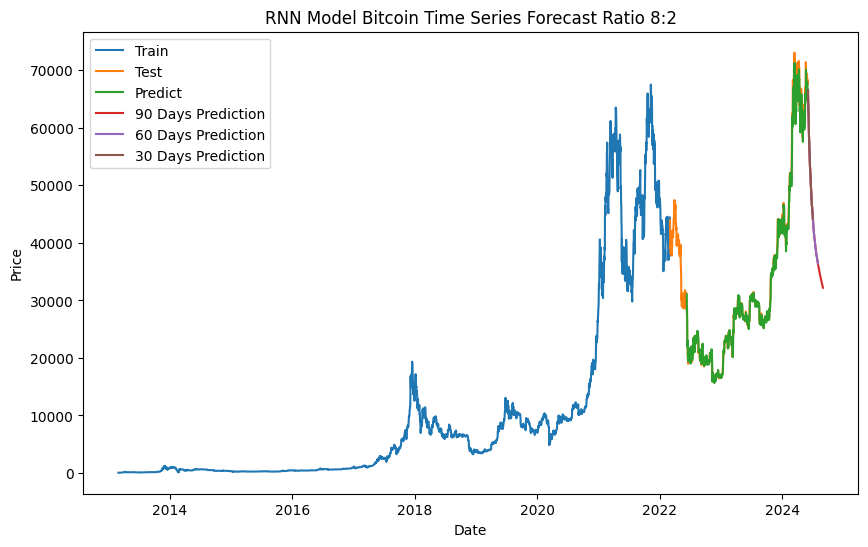

In [128]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))
dates = pd.to_datetime(data['Date'])

train_data_index = dates[:train_size]
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = dates[train_size:]
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(dates, test_predict_plot, label='Predict')

last_date = dates.iloc[-1]

# Plot next 90-days future
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
plt.plot(future_dates_90, forecast_90_output, label='90 Days Prediction')

# Plot next 60-days future
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
plt.plot(future_dates_60, forecast_60_output, label='60 Days Prediction')

# Plot next 30-days future
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates_30, forecast_30_output, label='30 Days Prediction')

# Adding legends and labels
plt.title('RNN Model Bitcoin Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [129]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

Testing RMSE: 1172.9967263959086
Testing MAE: 712.4246824143006
Testing MAPE: 2.060791762416921


# DATASET NASDAQ


In [130]:
# Load CSV File
df = pd.read_csv('NASDAQ Composite Historical Data.csv')
print(df)

           Date      Price       Open       High        Low     Vol. Change %
0     5/31/2024  16,735.02  16,771.90  16,789.27  16,445.54    1.81B   -0.01%
1     5/30/2024  16,737.08  16,878.63  16,900.46  16,690.36    1.11B   -1.08%
2     5/29/2024  16,920.58  16,879.35  16,989.60  16,873.97    1.15B   -0.58%
3     5/28/2024  17,019.88  16,988.31  17,032.65  16,917.51    1.10B    0.59%
4     5/24/2024  16,920.79  16,786.79  16,947.79  16,771.58  953.61M    1.10%
...         ...        ...        ...        ...        ...      ...      ...
2828   3/7/2013   3,232.09   3,224.50   3,235.10   3,221.47  365.78M    0.30%
2829   3/6/2013   3,222.37   3,233.31   3,233.44   3,217.67  377.54M   -0.05%
2830   3/5/2013   3,224.13   3,200.38   3,227.31   3,200.27  418.69M    1.32%
2831   3/4/2013   3,182.03   3,159.46   3,182.27   3,154.79  397.77M    0.39%
2832   3/1/2013   3,169.74   3,143.54   3,171.50   3,129.40  431.39M    0.30%

[2833 rows x 7 columns]


In [131]:
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
data = df
df1 = df_reversed['Price']
df1 = df1.str.replace(',', '').astype(float)

In [132]:
# Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

### RETIO 6:4

In [133]:
# Split Train and Test Data
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [134]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [135]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [136]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [137]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [138]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0063
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.2732e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0161e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.9691e-05
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.5908e-05
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.7617e-05
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.0711e-05
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.4930e-05
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.3210e-05
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.4721e-05
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.2133e-05
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.6335e-05
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.8062e-05
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.7644e-05
Epoch

In [139]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [140]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [141]:
last_input = test_data[-time_step:].reshape(1, -1)

In [142]:
# Forecast Next 30 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output30 = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output30.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output30.extend(yhat.tolist())
        i += 1
forecast_30_days = 30
forecast_30_output = scaler.inverse_transform(lst_output30)

In [143]:
# Forecast Next 60 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output60 = []
i = 0
while i < 60:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output60.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output60.extend(yhat.tolist())
        i += 1
forecast_60_days = 60
forecast_60_output = scaler.inverse_transform(lst_output60)

In [144]:
# Forecast Next 90 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output90.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output90.extend(yhat.tolist())
        i += 1
forecast_90_days = 90
forecast_90_output = scaler.inverse_transform(lst_output90)

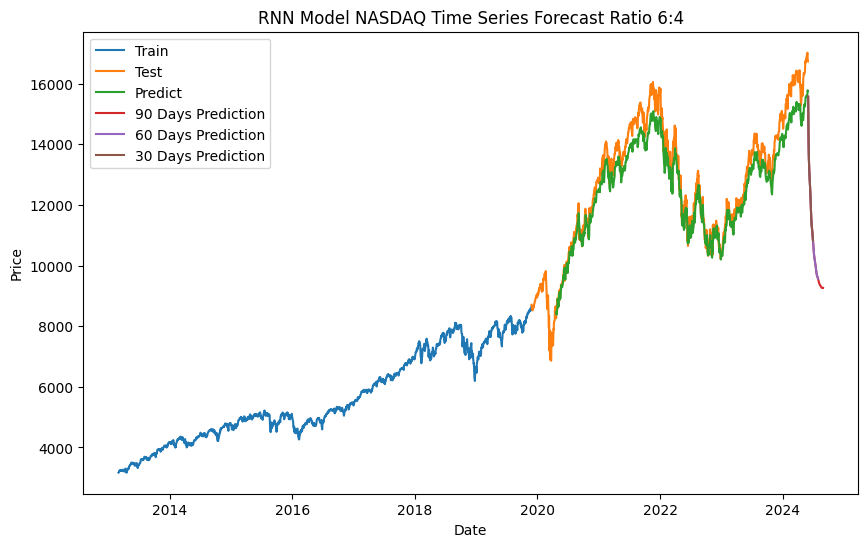

In [145]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))
dates = pd.to_datetime(data['Date'])

train_data_index = dates[:train_size]
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = dates[train_size:]
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(dates, test_predict_plot, label='Predict')

last_date = dates.iloc[-1]

# Plot next 90-days future
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
plt.plot(future_dates_90, forecast_90_output, label='90 Days Prediction')

# Plot next 60-days future
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
plt.plot(future_dates_60, forecast_60_output, label='60 Days Prediction')

# Plot next 30-days future
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates_30, forecast_30_output, label='30 Days Prediction')

# Adding legends and labels
plt.title('RNN Model NASDAQ Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [146]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

Testing RMSE: 553.0426961295368
Testing MAE: 463.15868609329624
Testing MAPE: 3.3418593260121003


### RETIO 7:3

In [147]:
# Split Train and Test Data
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [148]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [149]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [150]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [151]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [152]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0117
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.8720e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.4271e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.1214e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.8940e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.6927e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.5144e-04
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.5990e-04
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4311e-04
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1761e-04
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.2612e-04
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.2544e-04
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.1371e-04
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1634e-04
Epoch

In [153]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [154]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [155]:
last_input = test_data[-time_step:].reshape(1, -1)

In [156]:
# Forecast Next 30 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output30 = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output30.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output30.extend(yhat.tolist())
        i += 1
forecast_30_days = 30
forecast_30_output = scaler.inverse_transform(lst_output30)

In [157]:
# Forecast Next 60 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output60 = []
i = 0
while i < 60:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output60.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output60.extend(yhat.tolist())
        i += 1
forecast_60_days = 60
forecast_60_output = scaler.inverse_transform(lst_output60)

In [158]:
# Forecast Next 90 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output90.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output90.extend(yhat.tolist())
        i += 1
forecast_90_days = 90
forecast_90_output = scaler.inverse_transform(lst_output90)

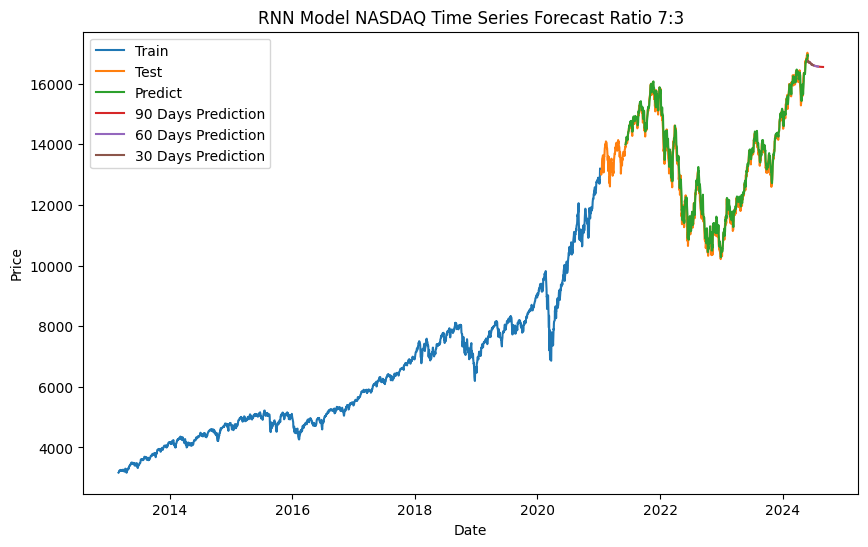

In [159]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))
dates = pd.to_datetime(data['Date'])

train_data_index = dates[:train_size]
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = dates[train_size:]
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(dates, test_predict_plot, label='Predict')

last_date = dates.iloc[-1]

# Plot next 90-days future
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
plt.plot(future_dates_90, forecast_90_output, label='90 Days Prediction')

# Plot next 60-days future
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
plt.plot(future_dates_60, forecast_60_output, label='60 Days Prediction')

# Plot next 30-days future
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates_30, forecast_30_output, label='30 Days Prediction')

# Adding legends and labels
plt.title('RNN Model NASDAQ Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [160]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

Testing RMSE: 211.27421074707763
Testing MAE: 162.7385950016689
Testing MAPE: 1.2539339464334918


### RETIO 8:2

In [161]:
# Split Train and Test Data
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [162]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [163]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [164]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [165]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [166]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0058
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9677e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9659e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8315e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7008e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5329e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7473e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4740e-04
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5941e-04
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4412e-04
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4230e-04
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.3994e-04
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7322e-04
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5078e-04
Epoch

In [167]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [168]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [169]:
last_input = test_data[-time_step:].reshape(1, -1)

In [170]:
# Forecast Next 30 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output30 = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output30.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output30.extend(yhat.tolist())
        i += 1
forecast_30_days = 30
forecast_30_output = scaler.inverse_transform(lst_output30)

In [171]:
# Forecast Next 60 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output60 = []
i = 0
while i < 60:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output60.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output60.extend(yhat.tolist())
        i += 1
forecast_60_days = 60
forecast_60_output = scaler.inverse_transform(lst_output60)

In [172]:
# Forecast Next 90 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output90.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output90.extend(yhat.tolist())
        i += 1
forecast_90_days = 90
forecast_90_output = scaler.inverse_transform(lst_output90)

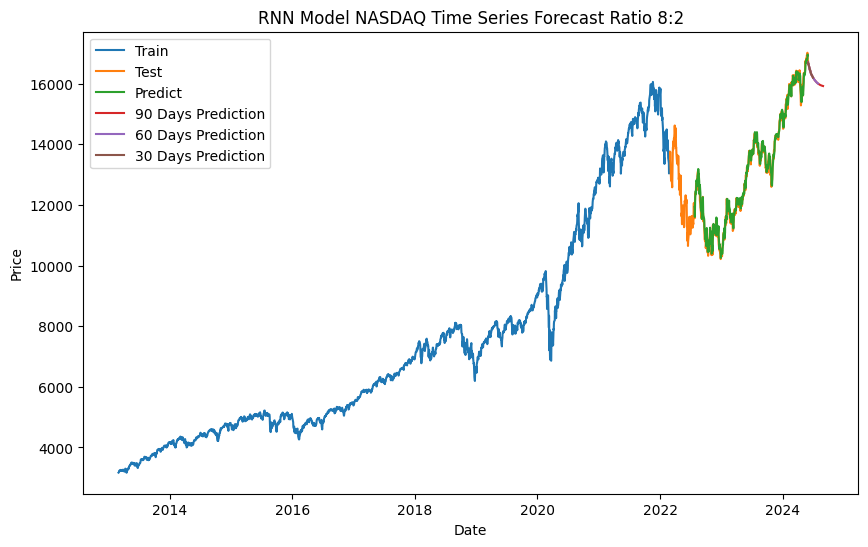

In [173]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))
dates = pd.to_datetime(data['Date'])

train_data_index = dates[:train_size]
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = dates[train_size:]
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(dates, test_predict_plot, label='Predict')

last_date = dates.iloc[-1]

# Plot next 90-days future
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
plt.plot(future_dates_90, forecast_90_output, label='90 Days Prediction')

# Plot next 60-days future
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
plt.plot(future_dates_60, forecast_60_output, label='60 Days Prediction')

# Plot next 30-days future
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates_30, forecast_30_output, label='30 Days Prediction')

# Adding legends and labels
plt.title('RNN Model NASDAQ Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [174]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

Testing RMSE: 180.09389395467832
Testing MAE: 143.62315685354076
Testing MAPE: 1.1283552412588909


# DATASET USD


In [175]:
# Load CSV File
df = pd.read_csv('US Dollar Index Futures Historical Data.csv')
print(df)

           Date    Price     Open     High      Low    Vol. Change %
0     5/31/2024  104.627  104.730  104.850  104.310  13.90K   -0.03%
1     5/30/2024  104.658  105.095  105.135  104.575  17.83K   -0.36%
2     5/29/2024  105.034  104.590  105.085  104.515  17.66K    0.47%
3     5/28/2024  104.539  104.490  104.560  104.260  11.02K   -0.09%
4     5/27/2024  104.638  104.645  104.670  104.485   3.09K    0.00%
...         ...      ...      ...      ...      ...     ...      ...
2902   3/7/2013   82.123   82.615   82.620   81.995  35.17K   -0.47%
2903   3/6/2013   82.507   82.020   82.640   81.975  26.04K    0.44%
2904   3/5/2013   82.147   82.210   82.300   81.955  25.02K   -0.13%
2905   3/4/2013   82.255   82.355   82.530   82.230  19.76K   -0.13%
2906   3/1/2013   82.358   82.010   82.580   81.850  34.83K    0.43%

[2907 rows x 7 columns]


In [176]:
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
data = df
df1 = df_reversed['Price']

In [177]:
# Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

### RETIO 6:4

In [178]:
# Split Train and Test Data
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [179]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [180]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [181]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [182]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [183]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0023
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.9138e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.1543e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.1618e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.6788e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.8491e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.9608e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.5369e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.6807e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.2007e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.3071e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.9651e-04
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.2583e-04
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9200e-04
Epoch

In [184]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [185]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [186]:
last_input = test_data[-time_step:].reshape(1, -1)

In [187]:
# Forecast Next 30 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output30 = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output30.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output30.extend(yhat.tolist())
        i += 1
forecast_30_days = 30
forecast_30_output = scaler.inverse_transform(lst_output30)

In [188]:
# Forecast Next 60 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output60 = []
i = 0
while i < 60:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output60.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output60.extend(yhat.tolist())
        i += 1
forecast_60_days = 60
forecast_60_output = scaler.inverse_transform(lst_output60)

In [189]:
# Forecast Next 90 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output90.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output90.extend(yhat.tolist())
        i += 1
forecast_90_days = 90
forecast_90_output = scaler.inverse_transform(lst_output90)

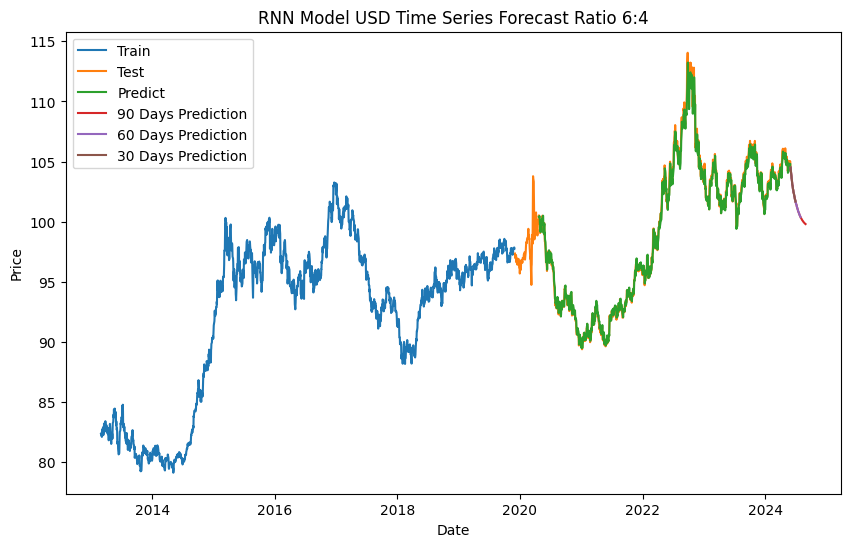

In [190]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))
dates = pd.to_datetime(data['Date'])

train_data_index = dates[:train_size]
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = dates[train_size:]
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(dates, test_predict_plot, label='Predict')

last_date = dates.iloc[-1]

# Plot next 90-days future
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
plt.plot(future_dates_90, forecast_90_output, label='90 Days Prediction')

# Plot next 60-days future
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
plt.plot(future_dates_60, forecast_60_output, label='60 Days Prediction')

# Plot next 30-days future
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates_30, forecast_30_output, label='30 Days Prediction')

# Adding legends and labels
plt.title('RNN Model USD Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [191]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

Testing RMSE: 0.48683955269898826
Testing MAE: 0.36130728183897204
Testing MAPE: 0.3579306751610106


### RETIO 7:3

In [192]:
# Split Train and Test Data
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [193]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [194]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [195]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [196]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [197]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0056
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.1969e-04
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.2525e-04
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9704e-04
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.8429e-04
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.8179e-04
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8410e-04
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.7825e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.4057e-04
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6014e-04
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6714e-04
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4704e-04
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.3143e-04
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.1158e-04
Epoch

In [198]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [199]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [200]:
last_input = test_data[-time_step:].reshape(1, -1)

In [201]:
# Forecast Next 30 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output30 = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output30.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output30.extend(yhat.tolist())
        i += 1
forecast_30_days = 30
forecast_30_output = scaler.inverse_transform(lst_output30)

In [202]:
# Forecast Next 60 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output60 = []
i = 0
while i < 60:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output60.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output60.extend(yhat.tolist())
        i += 1
forecast_60_days = 60
forecast_60_output = scaler.inverse_transform(lst_output60)

In [203]:
# Forecast Next 90 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output90.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output90.extend(yhat.tolist())
        i += 1
forecast_90_days = 90
forecast_90_output = scaler.inverse_transform(lst_output90)

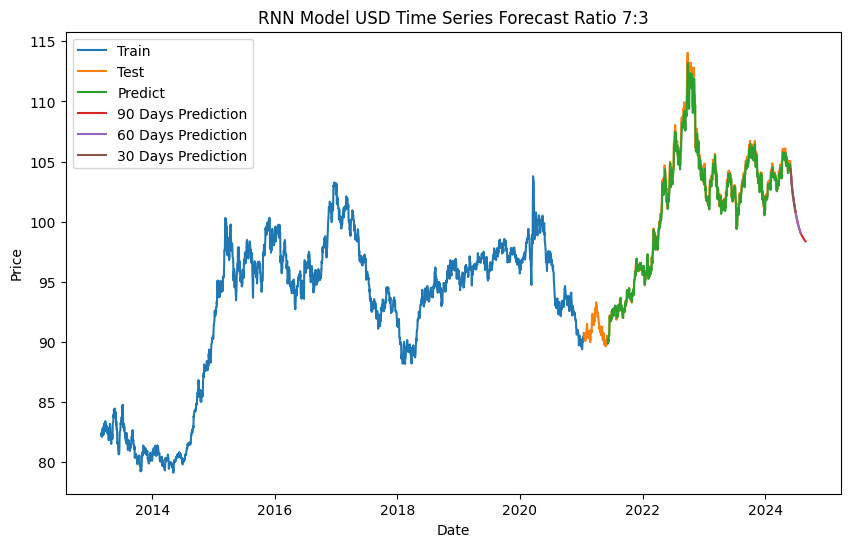

In [204]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))
dates = pd.to_datetime(data['Date'])

train_data_index = dates[:train_size]
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = dates[train_size:]
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(dates, test_predict_plot, label='Predict')

last_date = dates.iloc[-1]

# Plot next 90-days future
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
plt.plot(future_dates_90, forecast_90_output, label='90 Days Prediction')

# Plot next 60-days future
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
plt.plot(future_dates_60, forecast_60_output, label='60 Days Prediction')

# Plot next 30-days future
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates_30, forecast_30_output, label='30 Days Prediction')

# Adding legends and labels
plt.title('RNN Model USD Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [205]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

Testing RMSE: 0.5445805809219624
Testing MAE: 0.40597815645049906
Testing MAPE: 0.3931331829557052


### RETIO 8:2

In [206]:
# Split Train and Test Data
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [207]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [208]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [209]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [210]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [211]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0115
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.4648e-04
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.1690e-04
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.2195e-04
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0234e-04
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0681e-04
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8688e-04
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0060e-04
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.9178e-04
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.8412e-04
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.8820e-04
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.1539e-04
Epoch 13/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9431e-04
Epoch 14/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7452e-04
Epoch

In [212]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [213]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [214]:
last_input = test_data[-time_step:].reshape(1, -1)

In [215]:
# Forecast Next 30 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output30 = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output30.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output30.extend(yhat.tolist())
        i += 1
forecast_30_days = 30
forecast_30_output = scaler.inverse_transform(lst_output30)

In [216]:
# Forecast Next 60 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output60 = []
i = 0
while i < 60:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output60.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output60.extend(yhat.tolist())
        i += 1
forecast_60_days = 60
forecast_60_output = scaler.inverse_transform(lst_output60)

In [217]:
# Forecast Next 90 Days
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output90.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output90.extend(yhat.tolist())
        i += 1
forecast_90_days = 90
forecast_90_output = scaler.inverse_transform(lst_output90)

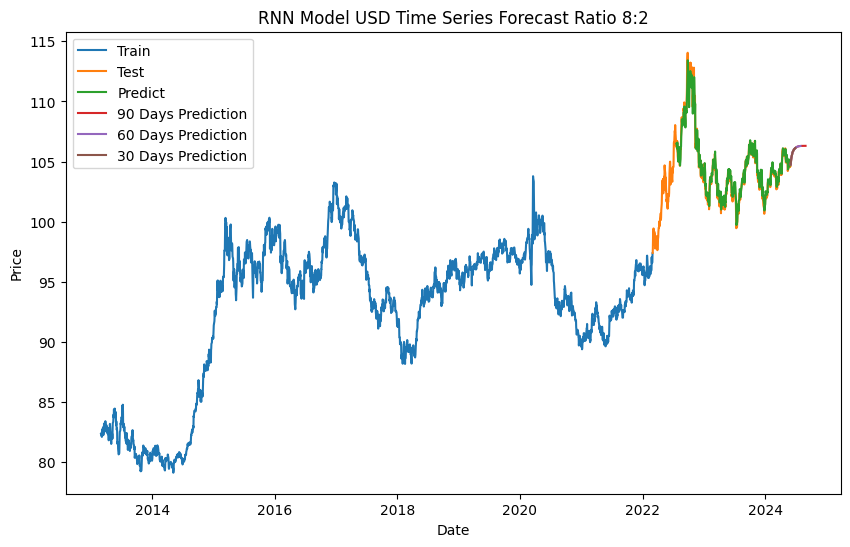

In [218]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))
dates = pd.to_datetime(data['Date'])

train_data_index = dates[:train_size]
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = dates[train_size:]
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(dates, test_predict_plot, label='Predict')

last_date = dates.iloc[-1]

# Plot next 90-days future
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
plt.plot(future_dates_90, forecast_90_output, label='90 Days Prediction')

# Plot next 60-days future
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
plt.plot(future_dates_60, forecast_60_output, label='60 Days Prediction')

# Plot next 30-days future
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates_30, forecast_30_output, label='30 Days Prediction')

# Adding legends and labels
plt.title('RNN Model USD Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [219]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

Testing RMSE: 0.5658990140601613
Testing MAE: 0.4231520559584521
Testing MAPE: 0.4022535789077325
